
# Incremental SVM vs Traditional SVM  
**Dataset:** Kaggle Fraud Detection Dataset  

---

## Objective
Traditional SVM needs full retraining whenever new data arrives — too slow for streaming systems.  
Incremental SVM (ISVM) updates the model continuously without forgetting old knowledge.

This notebook compares:
- Training time of Traditional SVM vs Incremental SVM  
- Accuracy comparison  
- Update time when new data streams in  
- Visualizations using Matplotlib  


In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

# Load dataset (user must upload the CSV file to /mnt/data)
df = pd.read_csv('fraudTrain.csv')  # CHANGE FILENAME IF NEEDED

df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [19]:
# Convert datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['month'] = df['trans_date_trans_time'].dt.month
df.drop(columns=['trans_date_trans_time'], inplace=True)

# Keep only numeric columns for now (simple approach)
df = df.select_dtypes(include=['number'])

# SAMPLE for speed
df = df.sample(20000, random_state=42)

In [20]:

y = df['is_fraud']
X = df.drop('is_fraud', axis=1)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


## Incremental SVM (ISVM) using `SGDClassifier` with hinge loss

In [28]:
# ============================================
#   SVM vs iSVM - Multi Batch Comparison
# ============================================

num_batches = 5
batch_size = len(X_train) // num_batches

svm_times = []
isvm_times = []
isvm_accuracies = []
svm_accuracies = []

classes = np.unique(y_train)

# New iSVM model
isvm_stream = SGDClassifier(loss='hinge')

print("Running batch comparison...\n")

for b in range(num_batches):
    print(f"=== Batch {b+1}/{num_batches} ===")

    start_idx = b * batch_size
    end_idx = (b + 1) * batch_size
    
    X_batch = X_train[start_idx:end_idx]
    y_batch = y_train.iloc[start_idx:end_idx]

    # ----------------------------
    # Traditional SVM (full retrain)
    # ----------------------------
    svm_model = SVC(kernel='rbf')

    start = time.time()
    svm_model.fit(X_batch, y_batch)
    t_svm = time.time() - start
    svm_times.append(t_svm)

    # test accuracy
    pred_svm = svm_model.predict(X_test)
    acc_svm = accuracy_score(y_test, pred_svm)
    svm_accuracies.append(acc_svm)

    print(f"SVM  : {t_svm:.4f}s | accuracy={acc_svm*100:.2f}")

    # ----------------------------
    # Incremental SVM (partial_fit)
    # ----------------------------
    start = time.time()
    isvm_stream.partial_fit(X_batch, y_batch, classes=classes if b == 0 else None)
    t_isvm = time.time() - start
    isvm_times.append(t_isvm)

    # test accuracy
    pred_isvm = isvm_stream.predict(X_test)
    acc_isvm = accuracy_score(y_test, pred_isvm)
    isvm_accuracies.append(acc_isvm)

    print(f"iSVM : {t_isvm:.4f}s | accuracy={acc_isvm*100:.2f}\n")

np.save("svm_times.npy", svm_times)
np.save("isvm_times.npy", isvm_times)

np.save("svm_acc.npy", svm_accuracies)
np.save("isvm_acc.npy", isvm_accuracies)



Running batch comparison...

=== Batch 1/5 ===
SVM  : 0.0526s | accuracy=99.62
iSVM : 0.0027s | accuracy=99.62

=== Batch 2/5 ===
SVM  : 0.0433s | accuracy=99.72
iSVM : 0.0018s | accuracy=99.15

=== Batch 3/5 ===
SVM  : 0.0507s | accuracy=99.67
iSVM : 0.0020s | accuracy=99.12

=== Batch 4/5 ===
SVM  : 0.0326s | accuracy=99.62
iSVM : 0.0016s | accuracy=99.40

=== Batch 5/5 ===
SVM  : 0.0201s | accuracy=99.62
iSVM : 0.0011s | accuracy=99.62



## Streaming New Data Simulation

## 📊 Visualization Results

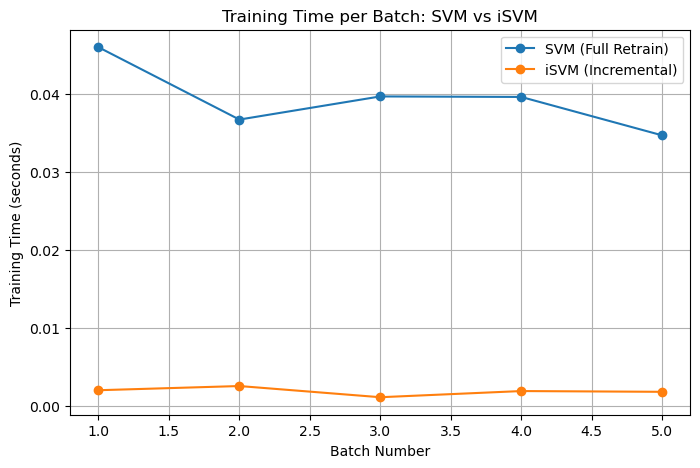

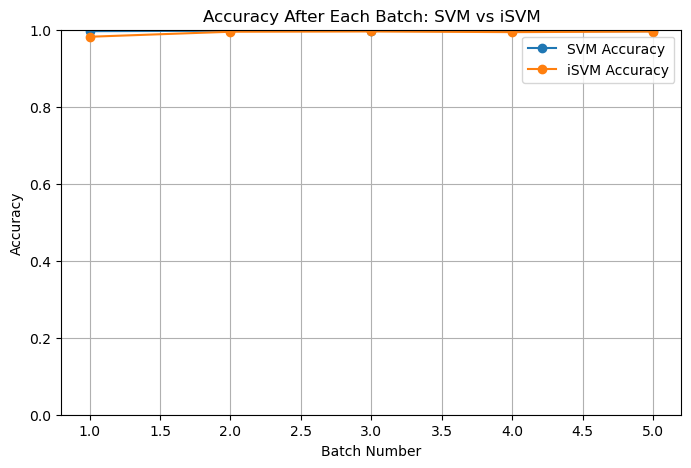

In [24]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_batches+1), svm_times, marker='o', label='SVM (Full Retrain)')
plt.plot(range(1, num_batches+1), isvm_times, marker='o', label='iSVM (Incremental)')
plt.title("Training Time per Batch: SVM vs iSVM")
plt.xlabel("Batch Number")
plt.ylabel("Training Time (seconds)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8,5))
plt.plot(range(1, num_batches+1), svm_accuracies, marker='o', label='SVM Accuracy')
plt.plot(range(1, num_batches+1), isvm_accuracies, marker='o', label='iSVM Accuracy')
plt.title("Accuracy After Each Batch: SVM vs iSVM")
plt.xlabel("Batch Number")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()
